# Testing - Explanation Credibility (All Attributes)
## Attribute(s) used to generate Rule : All
In this code, we aim to validate the explanations generated by the RDR model, which has been trained to imitate the original model. These explanations will be evaluated by an expert in the relevant field, specifically a **dentist**, to ensure its credibility.

* dataset : Dental implant failure
* source : https://doi.org/10.3390/app8050698
* Expert : Devy Yasodhara Lee

In [19]:
import sys
sys.path.append('../src/')
from rdr import RDR

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from joblib import load, dump

pd.options.display.max_columns = None
pd.options.display.max_rows = None

## 1. Load dataset

### 1.1. Load the dataset and store it in a variable named **df**

In [21]:
df = pd.read_csv("../data/dental_implant_failure.csv")
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           739 non-null    float64
 1   Gender                        747 non-null    int64  
 2   Systemic disease              741 non-null    float64
 3   Factors of missing            741 non-null    float64
 4   Tobacco smoking               719 non-null    float64
 5   Betel nut Chewing             719 non-null    float64
 6   Alcohol consumption           719 non-null    float64
 7   Departments                   744 non-null    float64
 8   Surgeon experience            744 non-null    float64
 9   Location of implant           747 non-null    int64  
 10  Bone density                  743 non-null    float64
 11  Timing of implant placement   740 non-null    float64
 12  Ridge augmentation            732 non-null    float64
 13  Maxil

None

### 1.2. Clean dataset

In [22]:
df.drop(columns=['Departments',
                 "Betel nut Chewing",
                 "Alcohol consumption",
                 "Surgeon experience",
                 "Angle of abutment"], inplace=True)
df.dropna(inplace=True)
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 701 entries, 0 to 746
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           701 non-null    float64
 1   Gender                        701 non-null    int64  
 2   Systemic disease              701 non-null    float64
 3   Factors of missing            701 non-null    float64
 4   Tobacco smoking               701 non-null    float64
 5   Location of implant           701 non-null    int64  
 6   Bone density                  701 non-null    float64
 7   Timing of implant placement   701 non-null    float64
 8   Ridge augmentation            701 non-null    float64
 9   Maxillary sinus augmentation  701 non-null    float64
 10  Implant system                701 non-null    int64  
 11  Fixture length                701 non-null    float64
 12  Fixture width                 701 non-null    float64
 13  Types of p

None

## 2. Create RDR model

### 2.1. Define categorical attributes

In [23]:
categorical_attr = [
    "Gender",
    "Systemic disease",
    "Factors of missing",
    "Tobacco smoking",
    "Location of implant",
    "Bone density",
    "Timing of implant placement",
    "Ridge augmentation",
    "Maxillary sinus augmentation",
    "Implant system",
    "Types of prosthesis",
    "Prosthesis fixation",
    "Dental implant failure"]

### 2.2. Define features and label and split dataset
train/test ratio = 80 : 20

In [24]:
label = df['Dental implant failure']
features = df.drop('Dental implant failure', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    label,
                                                    test_size=0.2,
                                                    random_state=42)

### 2.3. Load Random Forest Classifier model

In [25]:
rf = load("./models/all-attribute/rf_model.joblib")

### 2.4. Create Prediction dataset
To streamline the code, we'll initialize the predicted labels generated by the `RandomForestClassifier (rf)`. Instead of creating a separate prediction dataset, we'll directly reference the `features` and the `predicted labels` during the training of the RDR model.

In [26]:
predicted_label = rf.predict(features)

### 2.6. Train RDR model by using original dataset and predicted label

In [27]:
rdr = RDR(
        antecedent="1",
        categorical_attr=categorical_attr,
        total_precedent= 0)

rf_rdr = rdr.fit(features, pd.DataFrame(predicted_label))

#### 2.6.1. Save RDR model with Joblib

In [37]:
# filename = "rdr_model-all.joblib"
# filepath = "./models/all-attribute/" + filename

# sys.setrecursionlimit(10**6)
# dump(rf_rdr, filepath)

['./models/all-attribute/rdr_model-all.joblib']

In [29]:
rf_pred = rf.predict(X_test)
rf_rdr_pred = rf_rdr.predict(X_test)

print(f"RF accuracy score: {metrics.accuracy_score(y_test, rf_pred)}")
print(f"RDR accuracy score: {metrics.accuracy_score(y_test, rf_rdr_pred)}")
print(f"RDR imitation accuracy score: {metrics.accuracy_score(rf_pred, rf_rdr_pred)}")

RF accuracy score: 0.8297872340425532
RDR accuracy score: 0.8297872340425532
RDR imitation accuracy score: 1.0


In [30]:
rf_pred = rf.predict(features)
rf_rdr_pred = rf_rdr.predict(features)

print(f"RF accuracy score: {metrics.accuracy_score(label, rf_pred)}")
print(f"RDR accuracy score: {metrics.accuracy_score(label, rf_rdr_pred)}")
print(f"RDR imitation accuracy score: {metrics.accuracy_score(rf_pred, rf_rdr_pred)}")

RF accuracy score: 0.9514978601997147
RDR accuracy score: 0.9514978601997147
RDR imitation accuracy score: 1.0


In [31]:
# RF predicts correctly
# RDR has same prediction with RF
sample1 = features[(rf_pred == label) & (rf_rdr_pred == rf_pred)]
sample1 = sample1.sample(len(sample1) if len(sample1)< 5 else 5, random_state=42)
sample_label1 = label.loc[sample1.index]

# RF predicts correctly
# RDR has different prediction with RF
sample2 = features[(rf_pred == label) & (rf_rdr_pred != rf_pred)]
sample2 = sample2.sample(len(sample2) if len(sample2)< 5 else 5, random_state=42)
sample_label2 = label.loc[sample2.index]

# RF predicts wrongly
# RDR has same prediction with RF
sample3 = features[(rf_pred != label) & (rf_rdr_pred == rf_pred)]
sample3 = sample3.sample(len(sample3) if len(sample3)< 5 else 5, random_state=42)
sample_label3 = label.loc[sample3.index]

# RF predicts wrongly
# RDR has different prediction with RF
sample4 = features[(rf_pred != label) & (rf_rdr_pred != rf_pred)]
sample4 = sample4.sample(len(sample4) if len(sample4)< 5 else 5, random_state=42)
sample_label4 = label.loc[sample4.index]

In [32]:
display(sample1.shape)
display(sample2.shape)
display(sample3.shape)
display(sample4.shape)

(5, 15)

(0, 15)

(5, 15)

(0, 15)

Index                   : 740
Actual label            : 1
Predicted label         : [1]
Predicted label with RDR: [1.]


,Age,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Fixture length,Fixture width,Types of prosthesis,Prosthesis fixation
740,31.0,0,0.0,1.0,0.0,2,3.0,2.0,0.0,2.0,1,11.0,3.5,0.0,1.0


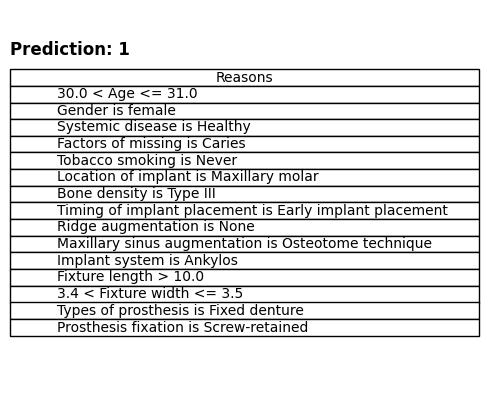

Index                   : 177
Actual label            : 0
Predicted label         : [0]
Predicted label with RDR: [0.]


,Age,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Fixture length,Fixture width,Types of prosthesis,Prosthesis fixation
177,55.0,1,0.0,1.0,0.0,5,2.0,2.0,1.0,0.0,0,10.0,4.1,0.0,0.0


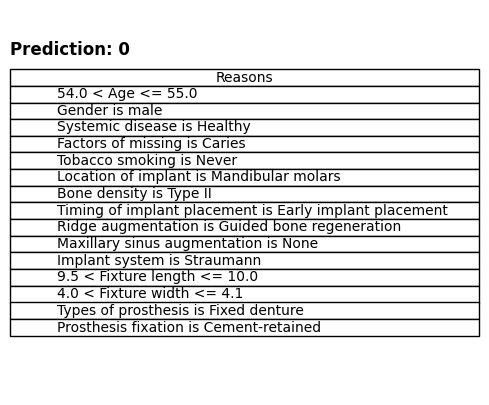

Index                   : 700
Actual label            : 0
Predicted label         : [0]
Predicted label with RDR: [0.]


,Age,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Fixture length,Fixture width,Types of prosthesis,Prosthesis fixation
700,46.0,0,0.0,2.0,2.0,5,2.0,2.0,1.0,0.0,1,9.5,3.5,0.0,0.0


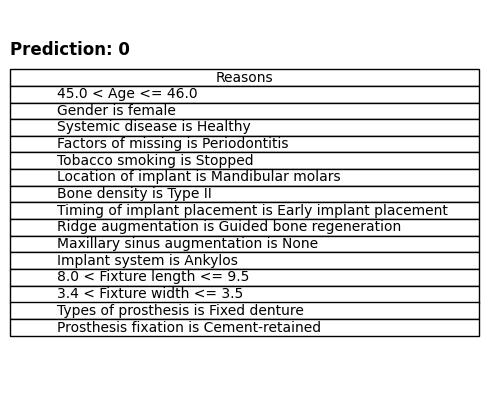

Index                   : 263
Actual label            : 1
Predicted label         : [1]
Predicted label with RDR: [1.]


,Age,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Fixture length,Fixture width,Types of prosthesis,Prosthesis fixation
263,53.0,1,0.0,1.0,0.0,0,3.0,2.0,1.0,0.0,3,13.0,4.3,0.0,1.0


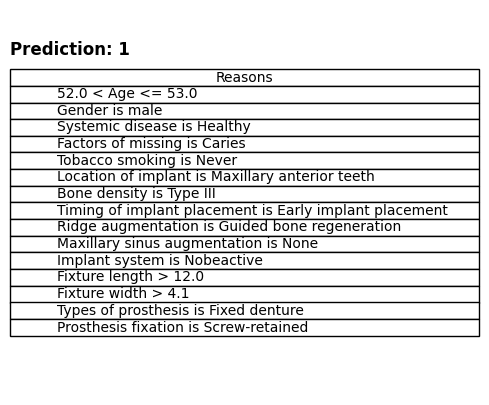

Index                   : 701
Actual label            : 0
Predicted label         : [0]
Predicted label with RDR: [0.]


,Age,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Fixture length,Fixture width,Types of prosthesis,Prosthesis fixation
701,46.0,0,0.0,2.0,2.0,5,2.0,2.0,1.0,0.0,1,9.5,3.5,0.0,1.0


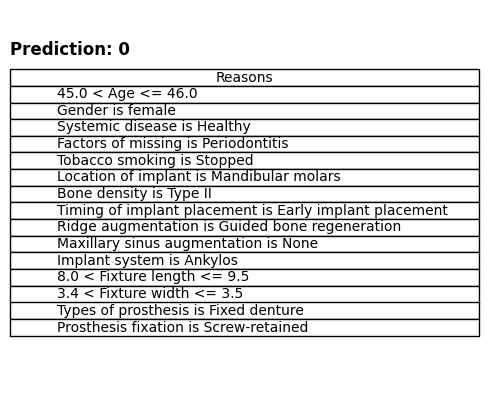

In [33]:
# RF predicts correctly
# RDR has same prediction with RF
for idx in sample1.index:
    print(f"Index                   : {idx}")
    print(f"Actual label            : {sample_label1.loc[idx]}")
    print(f"Predicted label         : {rf.predict(sample1.loc[[idx]])}")
    print(f"Predicted label with RDR: {rf_rdr.predict(sample1.loc[[idx]])}")
    output, reason, cornerstone = rf_rdr.explain_instance(sample1.loc[[idx]])

In [34]:
# RF predicts correctly
# RDR has different prediction with RF
for idx in sample2.index:
    print(f"Index                   : {idx}")
    print(f"Actual label            : {sample_label2.loc[idx]}")
    print(f"Predicted label         : {rf.predict(sample2.loc[[idx]])}")
    print(f"Predicted label with RDR: {rf_rdr.predict(sample2.loc[[idx]])}")
    output, reason, cornerstone = rf_rdr.explain_instance(sample2.loc[[idx]])

Index                   : 286
Actual label            : 0
Predicted label         : [1]
Predicted label with RDR: [1.]


,Age,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Fixture length,Fixture width,Types of prosthesis,Prosthesis fixation
286,57.0,0,0.0,3.0,0.0,0,3.0,2.0,1.0,0.0,0,10.0,4.1,0.0,1.0


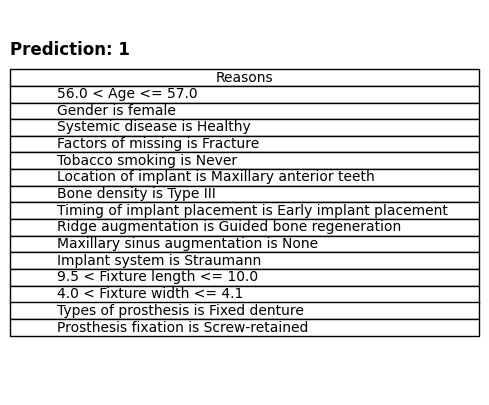

Index                   : 400
Actual label            : 0
Predicted label         : [1]
Predicted label with RDR: [1.]


,Age,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Fixture length,Fixture width,Types of prosthesis,Prosthesis fixation
400,38.0,1,0.0,3.0,0.0,5,3.0,2.0,0.0,0.0,0,10.0,4.1,0.0,0.0


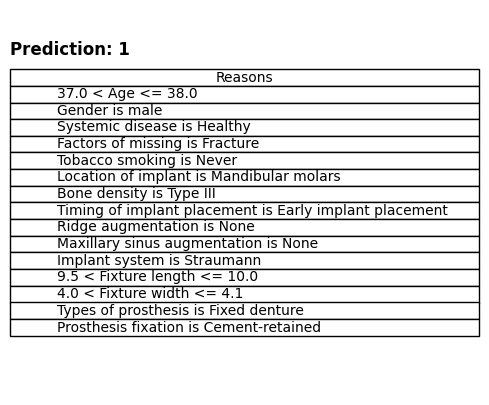

Index                   : 563
Actual label            : 0
Predicted label         : [1]
Predicted label with RDR: [1.]


,Age,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Fixture length,Fixture width,Types of prosthesis,Prosthesis fixation
563,56.0,1,0.0,2.0,1.0,5,2.0,2.0,0.0,0.0,5,11.5,4.5,0.0,0.0


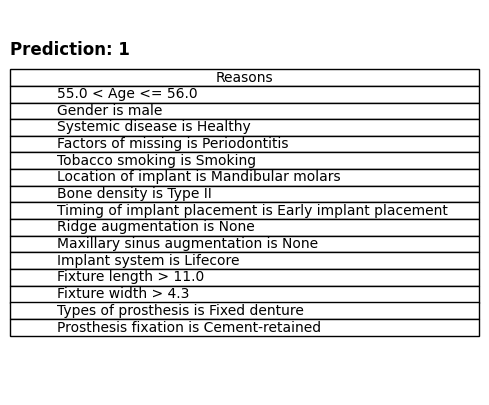

Index                   : 561
Actual label            : 0
Predicted label         : [1]
Predicted label with RDR: [1.]


,Age,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Fixture length,Fixture width,Types of prosthesis,Prosthesis fixation
561,56.0,1,0.0,2.0,1.0,4,2.0,2.0,0.0,0.0,5,10.0,3.75,0.0,0.0


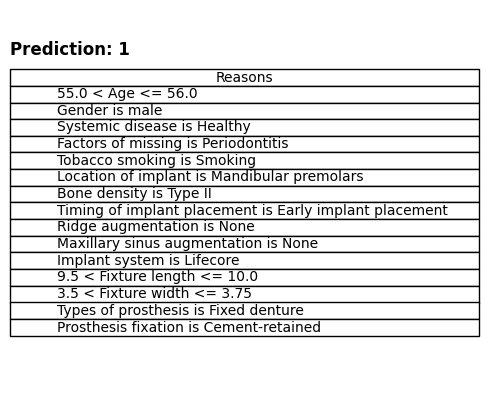

Index                   : 202
Actual label            : 0
Predicted label         : [1]
Predicted label with RDR: [1.]


,Age,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Fixture length,Fixture width,Types of prosthesis,Prosthesis fixation
202,59.0,1,5.0,2.0,0.0,5,2.0,2.0,1.0,0.0,0,10.0,4.1,0.0,0.0


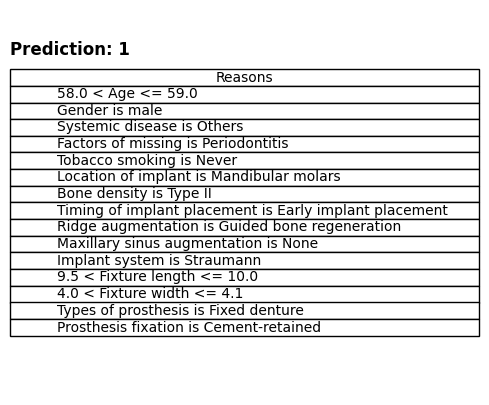

In [35]:
# RF predicts wrongly
# RDR has same prediction with RF
for idx in sample3.index:
    print(f"Index                   : {idx}")
    print(f"Actual label            : {sample_label3.loc[idx]}")
    print(f"Predicted label         : {rf.predict(sample3.loc[[idx]])}")
    print(f"Predicted label with RDR: {rf_rdr.predict(sample3.loc[[idx]])}")
    output, reason, cornerstone = rf_rdr.explain_instance(sample3.loc[[idx]])

In [36]:
# RF predicts wrongly
# RDR has different prediction with RF
for idx in sample4.index:
    print(f"Index                   : {idx}")
    print(f"Actual label            : {sample_label4.loc[idx]}")
    print(f"Predicted label         : {rf.predict(sample4.loc[[idx]])}")
    print(f"Predicted label with RDR: {rf_rdr.predict(sample4.loc[[idx]])}")
    output, reason, cornerstone = rf_rdr.explain_instance(sample4.loc[[idx]])